# Text classification with a Bag-of-Words approach: a case study for sentiment analysis

Classifying texts is the task of assigning a label to each of the elements of a dataset. In text classification, this task is achieved by analyzing and extracting information from text data. One patent example of such is the task of sentiment analysis.

Sentiment analysis is the task of identifying if the general sentiment of an excerpt should be considered "positive" or "negative". Although this is a well known and largely studied problem, it has gained a special importance in the last few years because of the need to monitor social media to find floating sentiments towards particular entities.

## Classification by logistic regression

One of the ways to perform classification is using Logistic Regression (LR). LR can be seen as a classification counterpart of linear regression. In linear regression, a vector $x$ of continuous features is multiplied by the transpose $w^T$ of a weight vector and has some bias added, yieding:

$$
z = xw^t + b.
$$

Note that this is equivalent to stating that $z = b+ \sum_{i=1}^n x_nw_n$, that is, there is one element in $w$ for each element in $x$ and this element represents the weight given to that element in the final sum.

Logistic Regression solves the problem of identifying the class ("positive" or "negative") that $x$ belongs to. In LR, the final output $y$ is given by $\sigma(z)$, where:

$$
y=\sigma(z)=\frac{1}{1+e^{-z}}.
$$

This allows interpreting $y$ as the probability that $x$ belongs to the "positive" class. Consequently, the weights $w$ and the bias $b$ can be optimized by minimizing the cross entropy loss regarding a labeled dataset.

Importantly, Logistic Regression calls for representing each element in the dataset using a vector. One of the solutions for such is the Bag-of-Words approach.

## Representing texts using Bag-of-words

The "bag" in bag of words brings the idea that all words from a text are put into a bag and then shuffled. In this case, each element from a text dataset is represented by a vector $x \in \mathbb{R}^V$, where $V$ is the number of words in the vocabulary. Thus, $x_i$ corresponds to the $i$-th word in the vocabulary.

The simplest way to find $x$ is to assume $x_i$ is $1$ if the corresponding word exists in the text, and $0$ if it does not, which makes each word follow a Bernoulli distribution. Another method is to make $x_i$ equal to the number of times the corresponding word appears in the text. This word count is called "Term Frequency" (TF).

Another method it to divide TF by the number of documents the corresponding words appears in (that is, the Document Frequency DF). This method is called Term Frequency - Inverse Document Frequency (TFIDF), and yields a vector that informs how much each word is relevant to separate that document from the whole collection.

Using BoW and LR is straightforward in Scikit Learn:

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create a pipeline with TfidfVectorizer and LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

## Dataset: IMDB dataset

In this study, we use the IMDB dataset because it is a well-known dataset. It is comprised of movie reviews extracted from the IMDB website. Reviews associated with a star rating of 4 our five are considered positive, whereas reviews associate with a star rating of 1 or 2 are considered negative. Reviews with a star rating of 3 are excluded form the dataset. The dataset is pre-divided into train and test sets:

In [2]:
import kagglehub
from pathlib import Path
# Download latest version
path = kagglehub.dataset_download("columbine/imdb-dataset-sentiment-analysis-in-csv-format")
path = Path(path)
#print("Path to dataset files:", path)
#print("Directory contents:", list(path.iterdir()))

In [3]:
import pandas as pd 
test_df = pd.read_csv(path / "Test.csv")
train_df = pd.read_csv(path / "Train.csv")
train_df.head(5)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [4]:
from sklearn.metrics import classification_report

pipeline.fit(train_df['text'], train_df['label'])
y_pred = pipeline.predict(test_df['text'])
report = classification_report(test_df['label'], y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2495
           1       0.89      0.91      0.90      2505

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



As we can see, the results are reasonable. Hence, we can proceed to analyze the model.


## Why did it classify as it did?

We can identify which words are typically the most important for classification. For such, we sweep the whole vocabulary and find $y$ corresponding to each of the inputs. The words with largest $y$ are associated with the "positive" class, whereas the words with lower $y$ are associated with the "negative" class. We can use `predict_proba` to find the values of $y$.

In [5]:
import numpy as np

# Extract the vocabulary and the classifier from the pipeline
vocab = pipeline.named_steps['tfidf'].vocabulary_
clf = pipeline.named_steps['clf']

# Get the feature names (words) from the TfidfVectorizer
feature_names = np.array(pipeline.named_steps['tfidf'].get_feature_names_out())
# Calculate predict_proba for each word
probabilities = pipeline.predict_proba(feature_names)

# Create a dataframe with words and their probabilities
proba_df = pd.DataFrame(probabilities, index=feature_names, columns=clf.classes_)
proba_df.rename(columns={1 : 'positive', 0 : 'negative'}, inplace=True)
proba_df = proba_df.sort_values(by='positive', ascending=False)

In [6]:
proba_df.head()

,negative,positive
great,0.000163,0.999837
excellent,0.000778,0.999222
best,0.003282,0.996718
wonderful,0.004254,0.995746
amazing,0.005403,0.994597


In [7]:
proba_df.tail()

,negative,positive
boring,0.999289,0.000711
awful,0.999702,0.000298
waste,0.999711,0.000289
bad,0.999897,0.000103
worst,0.999987,0.000013


As we can see, positive adjectives are associated with the positive class, while negative adjectives are associated with the negative class. This means that our system uses words that are meaningful towards our purpose. This can be seen as evidence that our model is not classifying based on spurious elements.

## How much data do we need?

It is common to see phrases such as "the more data, the better". However, this is only true to some extent. To find the possible impact of enlarging our dataset, we commonly use a Learning Curve. A Learning Curve is a curve made by changing the size of the training set and then evaluating the accuracy for each training dataset size.

The expected behavior is that the accuracy in the test set increases, while the accuracy in the train set decreases, until they asymptotically meet. This "meeting point" indicates the maximum amount of data that can lead to better results with the evaluated model, as well as the maximum accuracy for that same model. We can calculate the learning curve as:

In [8]:
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, train_df['text'], train_df['label'], cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.logspace(-2, 0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

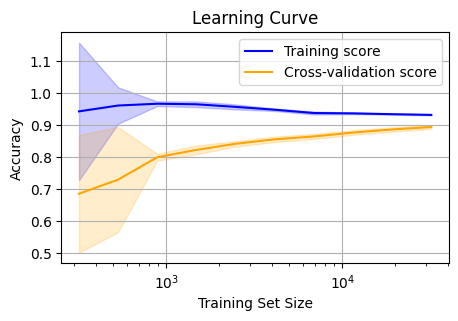

In [ ]:
# Plot the learning curve
plt.figure(figsize=(5, 3))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_scores_mean - 2*train_scores_std, train_scores_mean + 2*train_scores_std, color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange')
plt.fill_between(train_sizes, test_scores_mean - 2*test_scores_std, test_scores_mean + 2*test_scores_std, color='orange', alpha=0.2)

plt.title('Learning Curve')plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.semilogx()
plt.grid()
plt.show()

As we can see, if we had around $10^5$ data points (that is, a dataset at least twice as large as ours), our accuracy would probably reach around 92% accuracy. This means that adding more data would present diminishing gains.

## Conclusion

In this case study, we used a TFIDF+LR pipeline to classify sentiments in the IMDB dataset. As we can see, the words used for classification are meaningful towards writing positive or negative reviews, which indicates the model is well-fitting. Also, the accuracy in the train and test sets is relatively low, which indicates the dataset size is adequate for this problem.

Importantly, although the BoW model disregards the order in which words appear, it is able to capture the fact that some words are more likely to be used in particular contexts. Henceforth, this apparent disadvantage is not necessarily harmful to any classification problem.

# Activities

## Questions

**Remembering (Recall facts and basic concepts)**

1.  What is the main task being performed in this case study?
2.  What machine learning algorithm is used for the classification task?
3.  What technique is used to convert the text reviews into numerical feature vectors?
4.  What specific variant of Bag-of-Words is used in the Scikit-learn pipeline? (TF-IDF)
5.  What dataset is used for training and testing the model?
6.  How were the labels (positive/negative) determined for the reviews in the IMDB dataset?

**Understanding (Explain ideas or concepts)**

7.  Explain in your own words the core idea behind the Bag-of-Words (BoW) text representation.
8.  What is the purpose of the TF-IDF (Term Frequency-Inverse Document Frequency) weighting scheme compared to just counting word occurrences (Term Frequency)?
9.  Why is a Scikit-learn `Pipeline` useful for combining the vectorization and classification steps?
10. What does the learning curve plotted in the notebook illustrate? What do the two lines (training score and cross-validation score) represent?
11. Explain the rationale behind analyzing the `predict_proba` scores for individual words in the vocabulary. What was the author trying to determine?

**Applying (Use information in new situations)**

12. How would you modify the code cell defining the `pipeline` to use a simple count vectorizer (Term Frequency) instead of TF-IDF?
13. If you were given a new, unseen movie review text, what line(s) of code would you use (after the pipeline is trained) to predict whether it's positive or negative?
14. Based on the learning curve shown, if you doubled the training data again (to approx. 200,000 reviews), what would you *roughly* expect to happen to the cross-validation accuracy?

**Analyzing (Draw connections among ideas, compare/contrast, break down)**

15. Analyze the classification report. What does it tell you about the model's ability to correctly identify positive reviews versus negative reviews? Are there significant differences in precision or recall?
16. Compare the TF-IDF approach used here with a hypothetical approach that only uses word presence/absence (Bernoulli). What kind of information does TF-IDF capture that the simpler method doesn't?
17. What potential limitation of the Bag-of-Words approach is mentioned in the notebook's conclusion? Why might this limitation not be completely detrimental for this specific sentiment analysis task?
18. Looking at the learning curve, are the training and cross-validation scores close together or far apart as the training set size increases? What does this gap (or lack thereof) suggest about model variance or bias?

**Evaluating (Justify a stand or decision, critique)**

19. Evaluate the author's statement: "the dataset size is adequate for this problem." Do you agree or disagree based *only* on the evidence presented in the learning curve? Justify your position.
20. Critique the interpretability analysis performed (predicting probability for single words). While insightful, what potential inaccuracies or simplifications does this method introduce compared to how words contribute within a full review?

## Suggested answers

**Remembering**

1.  **What is the main task being performed in this case study?**
    *   Suggested Answer: The main task is sentiment analysis, which is a type of text classification aimed at identifying whether a piece of text expresses a positive or negative sentiment.

2.  **What machine learning algorithm is used for the classification task?**
    *   Suggested Answer: Logistic Regression (LR) is used for the classification task.

3.  **What technique is used to convert the text reviews into numerical feature vectors?**
    *   Suggested Answer: The Bag-of-Words (BoW) approach is used to convert text into numerical vectors.

4.  **What specific variant of Bag-of-Words is used in the Scikit-learn pipeline? (TF-IDF)**
    *   Suggested Answer: The specific variant used is Term Frequency-Inverse Document Frequency (TF-IDF), implemented via `TfidfVectorizer`.

5.  **What dataset is used for training and testing the model?**
    *   Suggested Answer: The IMDB movie review dataset is used.

6.  **How were the labels (positive/negative) determined for the reviews in the IMDB dataset?**
    *   Suggested Answer: Reviews with a star rating of 4 or 5 were considered positive (label 1), and reviews with a rating of 1 or 2 were considered negative (label 0). Reviews with a 3-star rating were excluded.

**Understanding**

7.  **Explain in your own words the core idea behind the Bag-of-Words (BoW) text representation.**
    *   Suggested Answer: BoW treats a text document as an unordered collection (like words thrown into a bag) of its words, disregarding grammar and word order. It represents the document as a numerical vector where each dimension corresponds to a unique word in the entire dataset's vocabulary, and the value in that dimension indicates the presence, count, or weighted frequency (like TF-IDF) of that word in the document.

8.  **What is the purpose of the TF-IDF (Term Frequency-Inverse Document Frequency) weighting scheme compared to just counting word occurrences (Term Frequency)?**
    *   Suggested Answer: TF-IDF aims to give higher importance to words that are frequent in a specific document but rare across the entire collection of documents. It down-weights words that appear very commonly everywhere (like "the", "a", "is"), which are less informative for distinguishing between documents, and boosts the weight of terms that are more unique or characteristic of a particular document.

9.  **Why is a Scikit-learn `Pipeline` useful for combining the vectorization and classification steps?**
    *   Suggested Answer: A `Pipeline` is useful because it chains the text vectorization (TF-IDF) and classification (Logistic Regression) steps into a single object. This simplifies the process of training and prediction, ensuring that the same transformations are applied consistently to both training and testing data. It also helps prevent data leakage, as the vectorizer is fitted only on the training data within the cross-validation folds when used with functions like `learning_curve`.

10. **What does the learning curve plotted in the notebook illustrate? What do the two lines (training score and cross-validation score) represent?**
    *   Suggested Answer: The learning curve illustrates how the model's performance (accuracy) changes as the amount of training data increases. The 'Training score' line shows the model's accuracy on the data it was trained on at each size point. The 'Cross-validation score' line shows the model's average accuracy on unseen data (validation sets from cross-validation) at each training size point, giving a better estimate of how well the model generalizes.

11. **Explain the rationale behind analyzing the `predict_proba` scores for individual words in the vocabulary. What was the author trying to determine?**
    *   Suggested Answer: The rationale was to interpret the model and understand *which* words it learned to associate most strongly with positive and negative sentiments. By feeding individual words (as documents) into the trained pipeline and getting their predicted probabilities, the author could identify the words that the model considered the strongest indicators of positivity (high probability for class 1) and negativity (high probability for class 0), providing evidence for whether the model learned meaningful features.

**Applying**

12. **How would you modify the code cell defining the `pipeline` to use a simple count vectorizer (Term Frequency) instead of TF-IDF?**
    *   Suggested Answer: You would import `CountVectorizer` from `sklearn.feature_extraction.text` and replace `TfidfVectorizer()` with `CountVectorizer()` in the pipeline definition:
        ```python
        from sklearn.feature_extraction.text import CountVectorizer
        pipeline = Pipeline([
            ('cv', CountVectorizer()), # Changed from 'tfidf', TfidfVectorizer()
            ('clf', LogisticRegression())
        ])
        ```

13. **If you were given a new, unseen movie review text, what line(s) of code would you use (after the pipeline is trained) to predict whether it's positive or negative?**
    *   Suggested Answer: Assuming the trained pipeline object is named `pipeline` and the new review text is stored in a variable `new_review`, you would use:
        ```python
        prediction = pipeline.predict([new_review])
        ```

14. **Based on the learning curve shown, if you doubled the training data again (to approx. 200,000 reviews), what would you *roughly* expect to happen to the cross-validation accuracy?**
    *   Suggested Answer: The learning curve shows the cross-validation score is starting to plateau around 40,000 samples (the end of the x-axis). Doubling the data again would likely lead to only very small, diminishing gains in accuracy, possibly increasing slightly towards the projected ~92%, but the improvement would be much less significant than the gains seen with smaller dataset sizes.

**Analyzing**

15. **Analyze the classification report. What does it tell you about the model's ability to correctly identify positive reviews versus negative reviews? Are there significant differences in precision or recall?**
    *   Suggested Answer: The classification report shows that the model performs very similarly well on both positive (1) and negative (0) classes. The precision, recall, and F1-scores are all around 0.90 for both classes. There are no significant differences, indicating the model is balanced in its ability to identify both positive and negative reviews correctly.

16. **Compare the TF-IDF approach used here with a hypothetical approach that only uses word presence/absence (Bernoulli). What kind of information does TF-IDF capture that the simpler method doesn't?**
    *   Suggested Answer: TF-IDF captures two key pieces of information that a simple Bernoulli (presence/absence) approach doesn't: 1) **Term Frequency:** How often a word appears within a single document (a word appearing multiple times might be more important than one appearing once). 2) **Inverse Document Frequency:** How common or rare a word is across all documents (rare words are often more discriminative). By combining these, TF-IDF provides a weighted score reflecting a word's importance, whereas Bernoulli only provides a binary indication of presence.

17. **What potential limitation of the Bag-of-Words approach is mentioned in the notebook's conclusion? Why might this limitation not be completely detrimental for this specific sentiment analysis task?**
    *   Suggested Answer: The limitation mentioned is that BoW disregards the order in which words appear, losing sequence and grammatical structure information. This might not be completely detrimental for sentiment analysis because the overall sentiment is often strongly conveyed by the presence of specific sentiment-bearing keywords (like "amazing," "awful," "boring," "great") regardless of their exact position or the sentence structure. The model can still learn that certain words are highly correlated with positive or negative labels.

18. **Looking at the learning curve, are the training and cross-validation scores close together or far apart as the training set size increases? What does this gap (or lack thereof) suggest about model variance or bias?**
    *   Suggested Answer: As the training set size increases, the training and cross-validation scores get closer together (converge). A small gap suggests low variance, meaning the model is not overfitting significantly to the training data and generalizes relatively well. If both scores converge at a level below desired performance, it could indicate higher bias (the model might be too simple to capture all the nuances). In this case, they converge around 90%, which is quite good, suggesting a reasonable balance, though the slight remaining gap and upward trend hint there's still a tiny bit of variance or potential for improvement with more data/model complexity.

**Evaluating**

19. **Evaluate the author's statement: "the dataset size is adequate for this problem." Do you agree or disagree based *only* on the evidence presented in the learning curve? Justify your position.**
    *   Suggested Answer: Based purely on the learning curve, the statement is reasonable but perhaps slightly optimistic regarding maximizing performance. The curve shows good performance (~90% accuracy) is achieved with the current data, and the cross-validation score is flattening, indicating diminishing returns from more data. So, it's adequate for achieving *good* results. However, the curve hasn't *completely* flattened, suggesting that more data (as the author estimates up to ~100k) *could* still provide a small improvement (potentially reaching ~92%). Therefore, while adequate for practical purposes and achieving high accuracy, it might not be fully adequate to squeeze out the absolute maximum performance possible with this model architecture.

20. **Critique the interpretability analysis performed (predicting probability for single words). While insightful, what potential inaccuracies or simplifications does this method introduce compared to how words contribute within a full review?**
    *   Suggested Answer: This method is a simplification because it treats each word in isolation, ignoring the context provided by surrounding words. In reality, word meaning and sentiment contribution can be context-dependent. For example:
        *   **Negation:** "not good" has the opposite sentiment of "good."
        *   **Intensifiers/Mitigators:** "very bad" vs. "a bit bad."
        *   **Sarcasm:** Context can completely flip the apparent sentiment of words.
        *   **Phrases:** Multi-word expressions can have specific meanings (e.g., "kick the bucket").
    The analysis provides a useful glimpse into which words the model *generally* associates with labels but doesn't reflect how these words interact within the structure of actual reviews.